In [7]:
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt

#### Prepare the machine
```
  sudo bash -c 'for ((i=0;i<$(nproc);i++)); do cpufreq-set -c $i -g performance; done'
  cat /sys/devices/system/cpu/cpu*/cpufreq/scaling_governor
```
#### Run the tests
```
  ./benchmarks/tinyopt_bench_tinyopt -r XML::out=../benchmarks/scripts/tinyopt.xml
  ./benchmarks/tinyopt_bench_ceres -r XML::out=../benchmarks/scripts/ceres.xml
```
#### Plot Results

In [8]:
def create_dataframe(data1, data2):
    """
    Creates a Pandas DataFrame from two lists of benchmark results.  Handles missing data robustly.

    Args:
        data1 (list): A list of dictionaries representing benchmark results from the first file.
        data2 (list): A list of dictionaries representing benchmark results from the second file.

    Returns:
        pandas.DataFrame: A DataFrame containing the benchmark data, or None if an error occurs.
    """
    df1 = pd.DataFrame(data1)
    df2 = pd.DataFrame(data2)
    df1.columns = ['Benchmark', 'Test', 'Tinyopt']
    df2.columns = ['Benchmark', 'Test', 'Ceres']
    df = pd.merge(df1, df2, how='left')

    # Calculate speedup, handle division by zero
    df["Speedup [%]"] = [
        (time2 / time1) * 100 - 100 if time1 != 0 and time2 != 0 else float("nan")
        for time1, time2 in zip(df["Tinyopt"], df["Ceres"])
    ]
    # Calculate speedup, handle division by zero
    df["Speedup [x]"] = [
        (time2 / time1) if time1 != 0 and time2 != 0 else float("nan")
        for time1, time2 in zip(df["Tinyopt"], df["Ceres"])
    ]

    return df

In [9]:
def parse_catch2_xml(file_path):
    """
    Parses a Catch2 benchmark XML output file.

    Args:
        file_path (str): The path to the XML file.

    Returns:
        list: A list of dictionaries, where each dictionary represents a benchmark result.
              Returns an empty list if the file is empty, not found, or not valid XML.
    """
    try:
        tree = ET.parse(file_path)
        root = tree.getroot()
        benchmarks = []
        for test_case in root.findall(".//TestCase"):
            for benchmark_results in test_case.findall("BenchmarkResults"):
                name_element = benchmark_results.find("mean")
                if any(
                    pattern in test_case.get("name") for pattern in ["3f", "6f", "Xf"]
                ):
                    continue
                mean = float(name_element.get("value")) * 1e-3  # in ms
                benchmarks.append(
                    {
                        "test": test_case.get("name"),
                        "bench": benchmark_results.get("name"),
                        "mean": mean,
                    }
                )

        return benchmarks
    except FileNotFoundError:
        print(f"Warning: File '{file_path}' not found.")
        return []
    except ET.ParseError as e:
        print(f"Warning: Could not parse file '{file_path}' as XML. Error: {e}")
        return []
    except Exception as e:
        print(f"An unexpected error occurred while parsing '{file_path}': {e}")
        return []

In [10]:
tinyopt = parse_catch2_xml('benchmarks/scripts/tinyopt.xml')
ceres = parse_catch2_xml('benchmarks/scripts/ceres.xml')

df = create_dataframe(tinyopt, ceres)
df


,Benchmark,Test,Tinyopt,Ceres,Speedup [%],Speedup [x]
0,Scalar,√2,3.01947,19.5144,546.285606,6.462856
1,Dense - Vec3,Prior [AD],11.78950,13.9951,18.708173,1.187082
2,Dense - Vec3,Prior,11.22100,14.4458,28.738972,1.287390
3,Dense - Vec6,Prior [AD],14.34430,17.4740,21.818423,1.218184
4,Dense - Vec6,Prior,14.87480,17.6444,18.619410,1.186194
5,Dense - Vec12,Prior [AD],41.35400,21.5684,-47.844465,0.521555
6,Dense - Vec12,Prior,35.20120,22.6147,-35.755883,0.642441
7,Dense - Vec21,Prior [AD],76.79010,42.6561,-44.451043,0.555490
8,Dense - Vec21,Prior,71.24700,35.7105,-49.877890,0.501221
9,Dense - VecX,Prior [AD],36.60040,21.3878,-41.564027,0.584360


In [11]:
def style_dataframe(df):
    """
    Styles the DataFrame according to the specified rules:
    - 'Speedup' column: Displayed as percentage with 2 decimal places,
                      red if negative, green if positive, orange if within +/- 5%.
    - 'Tinyopt' and 'Ceres' columns: The minimum value in each row is bolded.
    """

    def format_speedup(x):
        """Formats the 'Speedup' column as percentage with color."""
        if pd.isna(x):  # Handle potential NaN values
            return ""
        if -5 <= x <= 5:
            color = "orange"
        elif x > 0:
            color = "green"
        else:
            color = "red"
        return f'<span style="color: {color};">{x:.2f}%</span>'

    def format_speedupx(x):
        """Formats the 'Speedup' column as percentage with color."""
        if pd.isna(x):  # Handle potential NaN values
            return ""
        if 0.9 <= x <= 1.1:
            color = "orange"
        elif x > 1:
            color = "green"
        else:
            color = "red"
        return f'<span style="color: {color};">{x:.2f}x</span>'

    def bold_min_values(row):
        """Bolds the minimum of 'Tinyopt' and 'Ceres' in each row."""
        tinyopt = row["Tinyopt"]
        ceres = row["Ceres"]
        if pd.isna(tinyopt) and pd.isna(ceres):
            return ["", ""]  # Return empty strings if both are NaN
        elif pd.isna(tinyopt):
            return ["", "font-weight: bold;"]  # Bold only Ceres if Tinyopt is NaN
        elif pd.isna(ceres):
            return ["font-weight: bold;", ""]  # Bold only Tinyopt if Ceres is NaN

        if tinyopt < ceres:
            return ["font-weight: bold;", ""]
        elif ceres < tinyopt:
            return ["", "font-weight: bold;"]
        else:
            return ["", ""]  # Both are equal, don't bold either

    # Apply the styles
    styled_df = df.style.format(
        {
            "Speedup [%]": format_speedup,
            "Speedup [x]": format_speedupx,
            "Tinyopt": lambda x: f"{x:.2f}" if pd.notna(x) else "-",
            "Ceres": lambda x: f"{x:.2f}" if pd.notna(x) else "-",
        }
    ).apply(bold_min_values, axis=1, subset=["Tinyopt", "Ceres"])
    return styled_df


styled_df = style_dataframe(df)
styled_df

,Benchmark,Test,Tinyopt,Ceres,Speedup [%],Speedup [x]
0,Scalar,√2,3.02,19.51,546.29%,6.46x
1,Dense - Vec3,Prior [AD],11.79,14.00,18.71%,1.19x
2,Dense - Vec3,Prior,11.22,14.45,28.74%,1.29x
3,Dense - Vec6,Prior [AD],14.34,17.47,21.82%,1.22x
4,Dense - Vec6,Prior,14.87,17.64,18.62%,1.19x
5,Dense - Vec12,Prior [AD],41.35,21.57,-47.84%,0.52x
6,Dense - Vec12,Prior,35.20,22.61,-35.76%,0.64x
7,Dense - Vec21,Prior [AD],76.79,42.66,-44.45%,0.56x
8,Dense - Vec21,Prior,71.25,35.71,-49.88%,0.50x
9,Dense - VecX,Prior [AD],36.60,21.39,-41.56%,0.58x


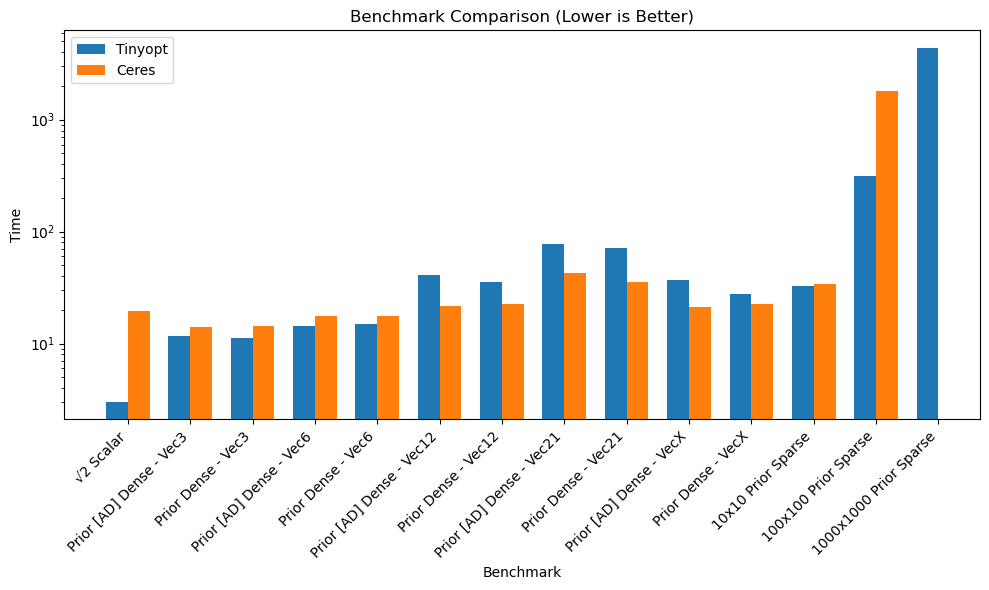

In [12]:
def plot_all_benchmarks(df, file1_name="Tinyopt", file2_name="Ceres"):
    """
    Plots the results of all benchmarks from the DataFrame in a grouped bar chart.
    """
    if df is None or df.empty:
        print("No data to plot.")
        return None

    if 'Benchmark' not in df.columns or 'Tinyopt' not in df.columns or 'Ceres' not in df.columns:
        print("Error: DataFrame is missing required columns.")
        return None

    # Prepare data for plotting
    benchmark_names = df['Test'] +' ' + df['Benchmark']
    time1_values = df['Tinyopt']
    time2_values = df['Ceres']

    # Create the grouped bar chart
    fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figure size as needed
    bar_width = 0.35
    index = range(len(benchmark_names))

    bar1 = ax.bar(index, time1_values, bar_width, label=file1_name)
    bar2 = ax.bar([i + bar_width for i in index], time2_values, bar_width, label=file2_name)

    # Add labels, title, and legend
    ax.set_yscale('log')
    ax.set_xlabel('Benchmark')
    ax.set_ylabel('Time')
    ax.set_title('Benchmark Comparison (Lower is Better)')
    ax.set_xticks([i + bar_width / 2 for i in index])
    ax.set_xticklabels(benchmark_names, rotation=45, ha="right")  # Rotate x-axis labels for readability
    ax.legend()

    plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plot_all_benchmarks(df)